# Loris CASSOULET - COLORISATION D'IMAGE

Le but de ce projet est de mettre en place une colorisation automatique de photos en noir et blanc. Pour y parvenir, les images ont été converties dans l'espace colorimétrique LAB, une technique qui permet de dissocier totalement l'intensité lumineuse de l'information chromatique. La démarche consiste alors à isoler le canal de luminosité (correspondant à l'image en niveaux de gris) pour l'utiliser comme donnée d'entrée, tandis que l'algorithme cherchera à prédire et reconstituer les deux canaux de couleur manquants en apprenant les correspondances implicites entre les niveaux de gris et les teintes réelles.



## Objectif :

* Dans un premier temps on cherchera à mettre en place un **réseau simple de convolution** pour à partir d'une image noir/blanc calculer son image couleur. Mot clefs : UpSampling2D. On cherchera à utiliser une métrique adaptée à la tâche.

* Ensuite, on utilisera un encodeur prédéterminé sur l'ensemble ImageNet sélectionné à partir des informations sur la page https://keras.io/api/applications/, dans notre cas ce sera **VGNet16**.


### Implémentation du premier modèle

Pour cette première approche, nous avons défini une architecture de réseau de neurones convolutionnels (CNN) séquentielle. Celle-ci prend en entrée le canal de luminosité (32x32) et intègre, conformément aux objectifs, une couche de sur-échantillonnage (UpSampling2D) pour traiter l'information spatiale avant de la compresser à nouveau pour la prédiction finale des deux canaux de couleur :

```
model = Sequential([
    Input(shape=(32, 32, 1)),
    Conv2D(64, (3,3), activation='relu', padding='same'),
    UpSampling2D((2,2)),  # 32x32 -> 64x64
    Conv2D(32, (3,3), activation='relu', padding='same'),
    Conv2D(32, (3,3), strides=2, activation='relu', padding='same'),  # 64x64 -> 32x32
    Conv2D(2, (3,3), activation='tanh', padding='same')
])
```

### Définition de la métrique

Pour évaluer la qualité perceptuelle de la colorisation, nous utilisons l'indice de similarité structurelle (SSIM, pour Structural SIMilarity). L'utilisation de cette métrique est pertinente pour la colorisation, car les métriques classiques comme la MSE (Mean Squared Error) présentent une limite majeure : elles favorisent le "moyennage". En cherchant à minimiser l'erreur numérique pure, la MSE tend à prédire une moyenne de toutes les couleurs possibles, ce qui résulte souvent en des images ternes voire grisâtres.

À l'inverse, la SSIM ne compare pas les pixels individuellement, mais analyse des fenêtres de pixels pour évaluer la luminance, le contraste et la structure.

Elle mime la perception visuelle humaine en vérifiant que les contours de la couleur prédite s'alignent avec les contours de l'objet dans l'image originale. Elle force ainsi le modèle à produire des structures cohérentes plutôt que de simples valeurs numériques exactes, garantissant un résultat visuellement plus net et naturel.


### Approche par Transfer Learning : VGG16

J'ai choisi le VGG16 car c'est un modèle « standard », simple d'utilisation et adapté à l'apprentissage par transfert. D'un point de vue pratique, sa taille d'entrée par défaut de 224x224 est moins imposante que d'autres architectures de la liste Keras, ce qui le rend plus léger et bien plus facile à adapter à nos images de faible résolution (32x32). De plus, sa petite taille par rapport à d'autre modèle est aussi un avantage.

## CNN Simple

169001437/169001437 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 2)      │           578 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,930 (113.01 KB)

 Trainable params: 28,930 (113.01 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 23s 50ms/step - loss: 0.0157 - ssim_metric: 0.7518 - val_loss: 0.0154 - val_ssim_metric: 0.7589
Epoch 2/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - loss: 0.0152 - ssim_metric: 0.7555 - val_loss: 0.0154 - val_ssim_metric: 0.7585
Epoch 3/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - loss: 0.0151 - ssim_metric: 0.7540 - val_loss: 0.0153 - val_ssim_metric: 0.7582
Epoch 4/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 21s 35ms/step - loss: 0.0150 - ssim_metric: 0.7522 - val_loss: 0.0151 - val_ssim_metric: 0.7549
Epoch 5/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 20s 35ms/step - loss: 0.0148 - ssim_metric: 0.7518 - val_loss: 0.0152 - val_ssim_metric: 0.7447
Epoch 6/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 20s 34ms/step - loss: 0.0149 - ssim_metric: 0.7492 - val_loss: 0.0149 - val_ssim_metric: 0.7519
Epoch 7/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - loss: 0.0149 - ssim_metric: 0.7472 - val_loss: 0.0151 - val_ssim_metric: 0.7505
Epoch 8/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 21s 34ms

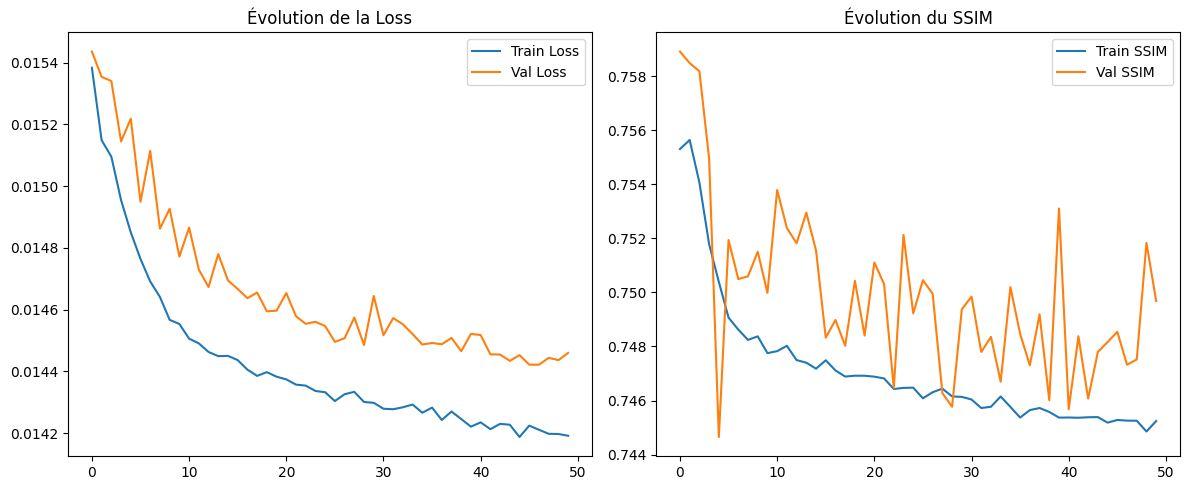

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from keras.layers import Input, Conv2D, UpSampling2D
from keras.models import Sequential

# Chargement des données
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar100.load_data(label_mode="fine")
Img = x_train 

# Conversion en Lab
X = []
Y = []
for i in range(0, Img.shape[0]):
    im = Img[i]
    im = cv2.cvtColor(im, cv2.COLOR_RGB2LAB)
    X.append(np.float32(im[:, :, 0:1]) / 255)
    Y.append(np.float32(im[:, :, 1:]) / 128 - 1)
X = np.array(X)
Y = np.array(Y)

# Shuffle des données (X, Y et x_train en même temps)
indices = np.arange(len(X))
np.random.seed(42)
np.random.shuffle(indices)

X_shuffled = X[indices]
Y_shuffled = Y[indices]
x_train_shuffled = x_train[indices]  # Important pour les affichages, et 

# Split 80/20
split_idx = int(0.8 * len(X))
X_train = X_shuffled[:split_idx]
Y_train = Y_shuffled[:split_idx]
X_test = X_shuffled[split_idx:]
Y_test = Y_shuffled[split_idx:]

x_train_rgb = x_train_shuffled[:split_idx]
x_test_rgb = x_train_shuffled[split_idx:]


# 1er CNN avec keras.layers.UpSampling2D
model = Sequential([
    Input(shape=(32, 32, 1)),
    Conv2D(64, (3,3), activation='relu', padding='same'),
    UpSampling2D((2,2)),  # 32x32 -> 64x64
    Conv2D(32, (3,3), activation='relu', padding='same'),
    Conv2D(32, (3,3), strides=2, activation='relu', padding='same'),  # 64x64 -> 32x32
    Conv2D(2, (3,3), activation='tanh', padding='same')
])

model.summary()

# Métrique SSIM 
import tensorflow as tf
def ssim_metric(y_true, y_pred):
    return tf.image.ssim((y_true + 1)/2, (y_pred + 1)/2, max_val=1.0)

model.compile(optimizer='adam', loss='mse', metrics=[ssim_metric])

# Entraînement avec historique
history = model.fit(X_train, Y_train,
                    epochs=50,
                    batch_size=128,
                    validation_data=(X_test, Y_test))

# Courbes d'apprentissage
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Évolution de la Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['ssim_metric'], label='Train SSIM')
plt.plot(history.history['val_ssim_metric'], label='Val SSIM')
plt.title('Évolution du SSIM')
plt.legend()

plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


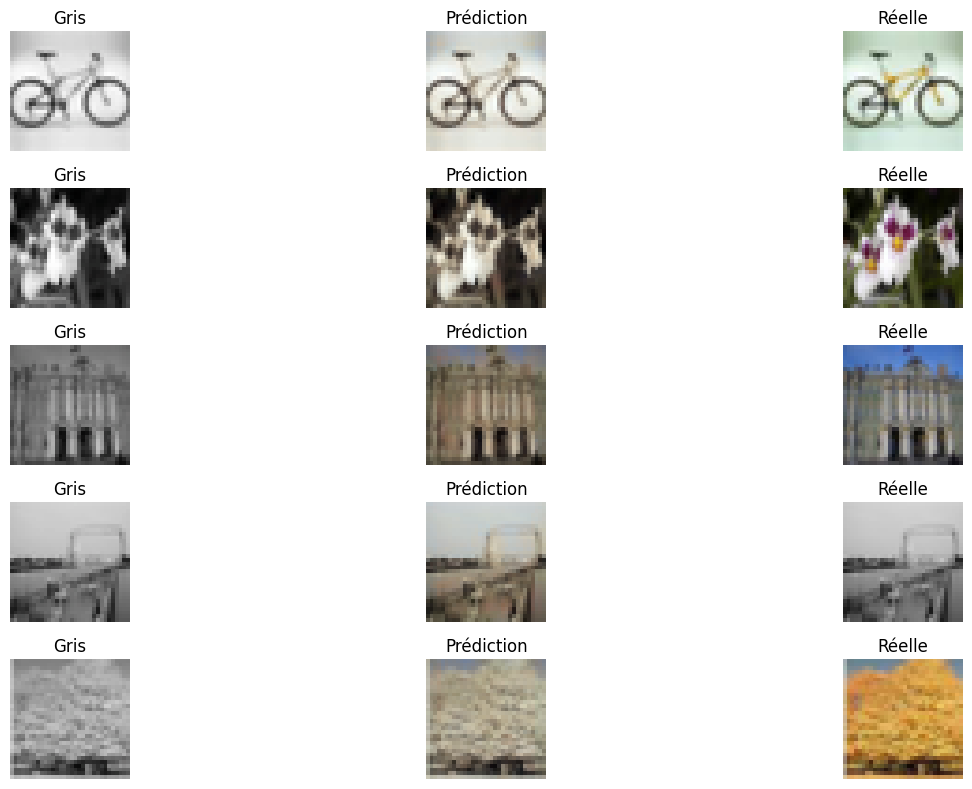

In [3]:
# Visualisation des résultats
def lab_to_rgb(L, AB):
    L = (L * 255).astype(np.uint8)
    AB = (AB * 128 + 128).astype(np.uint8)
    lab = np.concatenate([L, AB], axis=-1)
    return cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)

indices = np.random.choice(len(X_test), 5)

plt.figure(figsize=(15, 8))
for i, idx in enumerate(indices):
    # Image originale en niveaux de gris
    L = X_test[idx]
    gray = lab_to_rgb(L, np.zeros_like(Y_test[idx]))

    # Prédiction
    pred = model.predict(L[np.newaxis, ...])[0]
    color_pred = lab_to_rgb(L, pred)

    # Image réelle
    #real = x_test[idx]
    real = x_test_rgb[idx]


    # Affichage
    plt.subplot(5, 3, i*3+1)
    plt.imshow(gray)
    plt.title('Gris')
    plt.axis('off')

    plt.subplot(5, 3, i*3+2)
    plt.imshow(color_pred)
    plt.title('Prédiction')
    plt.axis('off')

    plt.subplot(5, 3, i*3+3)
    plt.imshow(real)
    plt.title('Réelle')
    plt.axis('off')

plt.tight_layout()
plt.show()

# VGG16

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 32, 32, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 32, 32, 3) │          0 │ input_layer_4[0]… │
│ (Concatenate)       │                   │            │ input_layer_4[0]… │
│                     │                   │            │ input_layer_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vgg16 (Functional)  │ (None, 1, 1, 512) │ 14,714,688 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_6     │ (None, 2, 2, 512) │          0 │ vgg16[0][0]       │
│ (UpSampling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 2, 2, 512) │  2,359,808 │ up_sampling2d_6[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_7     │ (None, 4, 4, 512) │          0 │ conv2d_10[0][0]   │
│ (UpSampling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 4, 4, 256) │  1,179,904 │ up_sampling2d_7[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_8     │ (None, 8, 8, 256) │          0 │ conv2d_11[0][0]   │
│ (UpSampling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 8, 8, 128) │    295,040 │ up_sampling2d_8[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_9     │ (None, 16, 16,    │          0 │ conv2d_12[0][0]   │
│ (UpSampling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_13 (Conv2D)  │ (None, 16, 16,    │     73,792 │ up_sampling2d_9[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_10    │ (None, 32, 32,    │          0 │ conv2d_13[0][0]   │
│ (UpSampling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_14 (Conv2D)  │ (None, 32, 32,    │     18,464 │ up_sampling2d_10… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_15 (Conv2D)  │ (None, 32, 32, 2) │        578 │ conv2d_14[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 18,642,274 (71.11 MB)

 Trainable params: 3,927,586 (14.98 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

Epoch 1/25
313/313 ━━━━━━━━━━━━━━━━━━━━ 40s 96ms/step - loss: 0.0224 - ssim_metric: 0.7294 - val_loss: 0.0145 - val_ssim_metric: 0.7515
Epoch 2/25
313/313 ━━━━━━━━━━━━━━━━━━━━ 15s 48ms/step - loss: 0.0143 - ssim_metric: 0.7494 - val_loss: 0.0144 - val_ssim_metric: 0.7514
Epoch 3/25
313/313 ━━━━━━━━━━━━━━━━━━━━ 15s 47ms/step - loss: 0.0140 - ssim_metric: 0.7476 - val_loss: 0.0142 - val_ssim_metric: 0.7518
Epoch 4/25
313/313 ━━━━━━━━━━━━━━━━━━━━ 20s 47ms/step - loss: 0.0140 - ssim_metric: 0.7484 - val_loss: 0.0143 - val_ssim_metric: 0.7521
Epoch 5/25
313/313 ━━━━━━━━━━━━━━━━━━━━ 15s 47ms/step - loss: 0.0138 - ssim_metric: 0.7503 - val_loss: 0.0142 - val_ssim_metric: 0.7513
Epoch 6/25
313/313 ━━━━━━━━━━━━━━━━━━━━ 15s 47ms/step - loss: 0.0137 - ssim_metric: 0.7500 - val_loss: 0.0141 - val_ssim_metric: 0.7517
Epoch 7/25
313/313 ━━━━━━━━━━━━━━━━━━━━ 15s 49ms/step - loss: 0.0136 - ssim_metric: 0.7497 - val_loss: 0.0142 - val_ssim_metric: 0.7520
Epoch 8/25
313/313 ━━━━━━━━━━━━━━━━━━━━ 20s 47ms

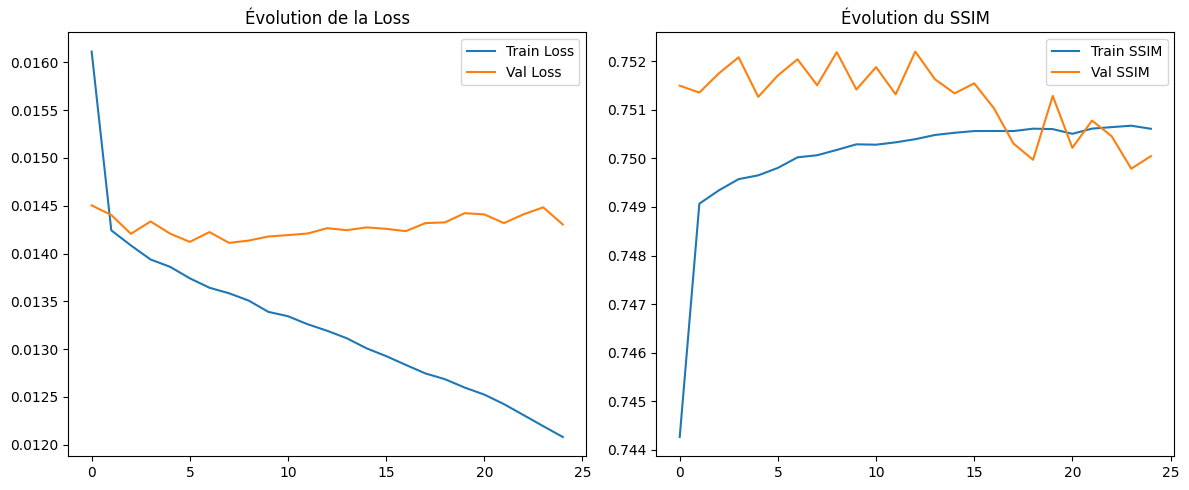

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


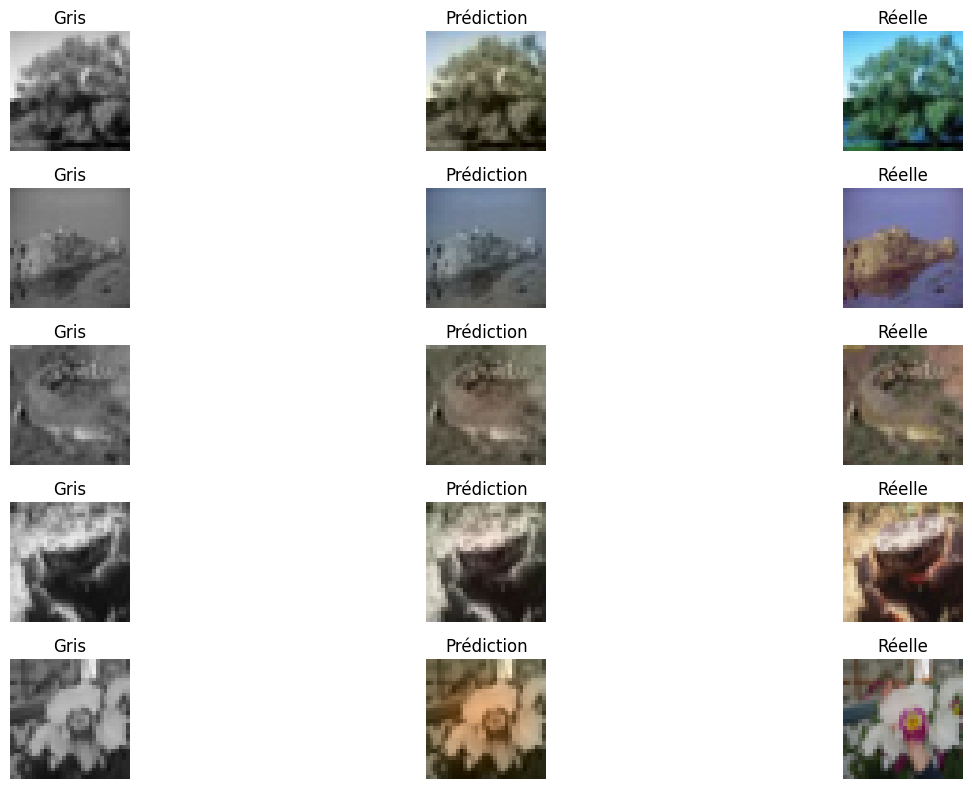

In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from keras.layers import Input, Conv2D, UpSampling2D, Concatenate
from keras.models import Model
from keras.applications import VGG16
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.optimizers import Adam
from keras.layers import Lambda


# Modèle VGG16
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
for layer in base_model.layers:
    layer.trainable = False

# Architecture du modèle
input_gray = Input(shape=(32, 32, 1))
input_rgb = Concatenate(axis=-1)([input_gray, input_gray, input_gray])
encoder_output = base_model(input_rgb)

x = UpSampling2D((2, 2))(encoder_output)
x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
output_ab = Conv2D(2, (3, 3), activation='tanh', padding='same')(x)

modelbis = Model(inputs=input_gray, outputs=output_ab)
modelbis.compile(optimizer=Adam(), loss='mse', metrics=[ssim_metric])

# Résumé
modelbis.summary()


# Entraînement
history = modelbis.fit(X_train, Y_train,
                       epochs=25,
                       batch_size=128,
                       validation_data=(X_test, Y_test))


# Courbes d'apprentissage
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Évolution de la Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['ssim_metric'], label='Train SSIM')
plt.plot(history.history['val_ssim_metric'], label='Val SSIM')
plt.title('Évolution du SSIM')
plt.legend()

plt.tight_layout()
plt.show()

# Visualisation des résultats
def lab_to_rgb(L, AB):
    L = (L * 255).astype(np.uint8)
    AB = (AB * 128 + 128).astype(np.uint8)
    lab = np.concatenate([L, AB], axis=-1)
    return cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)

indices = np.random.choice(len(X), 5)

plt.figure(figsize=(15, 8))
for i, idx in enumerate(indices):
    L = X[idx]
    gray = lab_to_rgb(L, np.zeros_like(Y[idx]))

    pred = modelbis.predict(L[np.newaxis, ...])[0]
    color_pred = lab_to_rgb(L, pred)

    real = x_train[idx]

    plt.subplot(5, 3, i * 3 + 1)
    plt.imshow(gray)
    plt.title('Gris')
    plt.axis('off')

    plt.subplot(5, 3, i * 3 + 2)
    plt.imshow(color_pred)
    plt.title('Prédiction')
    plt.axis('off')

    plt.subplot(5, 3, i * 3 + 3)
    plt.imshow(real)
    plt.title('Réelle')
    plt.axis('off')

plt.tight_layout()
plt.show() #1 maarche mettre 13 epoch


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━

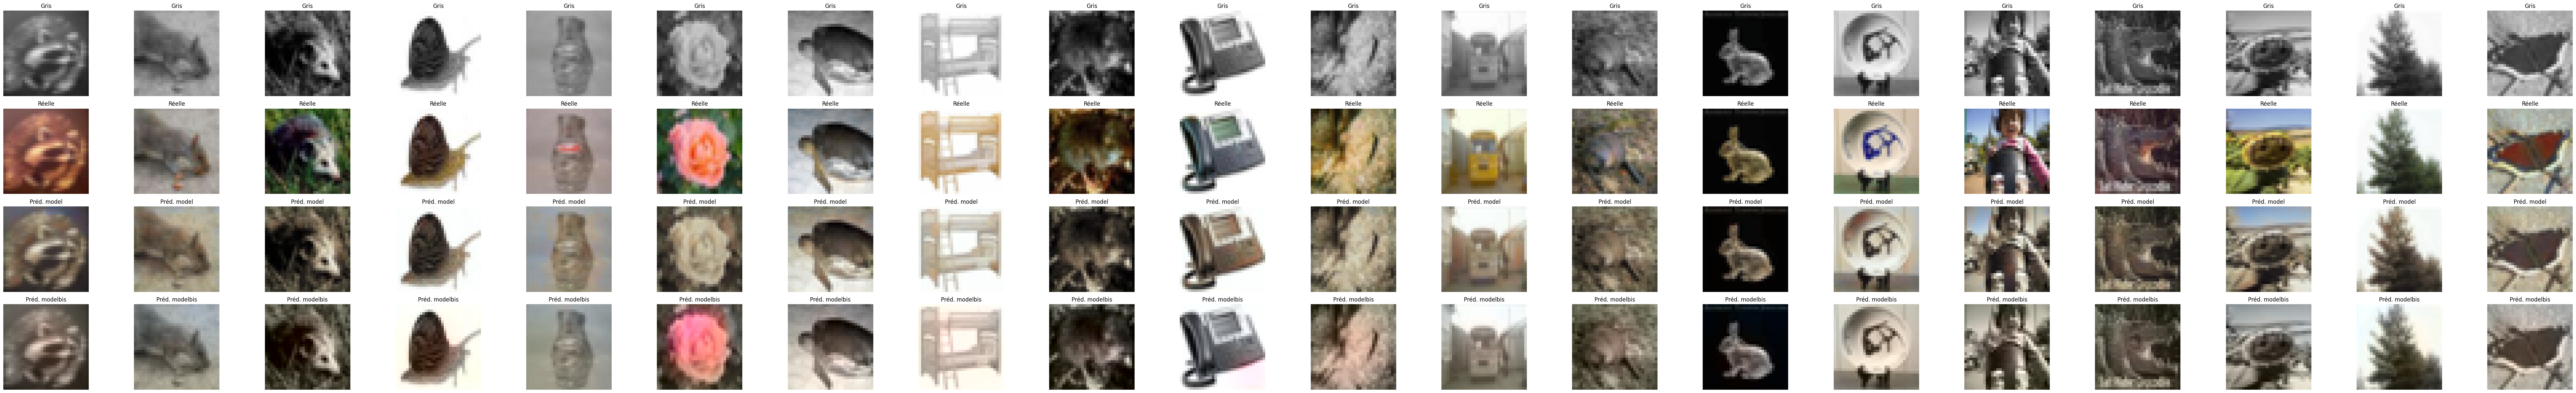

In [7]:
def compare_models(X, Y, x_rgb, model, modelbis, n=5):
    """
    Compare deux modèles de colorisation : `model` et `modelbis`.
    Affiche pour chaque image :
    - Niveaux de gris
    - Image réelle
    - Prédiction du modèle 1
    - Prédiction du modèle 2
    """
    def lab_to_rgb(L, AB):
        L = (L * 255).astype(np.uint8)
        AB = (AB * 128 + 128).astype(np.uint8)
        lab = np.concatenate([L, AB], axis=-1)
        return cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)

    indices = np.random.choice(len(X), n)

    plt.figure(figsize=(4 * n, 12))

    for i, idx in enumerate(indices):
        L = X[idx]
        real_ab = Y[idx]
        real_rgb = x_rgb[idx]

        # Image en niveaux de gris
        gray = lab_to_rgb(L, np.zeros_like(real_ab))

        # Prédiction model
        pred1 = model.predict(L[np.newaxis, ...])[0]
        color_pred1 = lab_to_rgb(L, pred1)

        # Prédiction modelbis
        pred2 = modelbis.predict(L[np.newaxis, ...])[0]
        color_pred2 = lab_to_rgb(L, pred2)

        # Affichage ligne 1 : gris
        plt.subplot(4, n, i + 1)
        plt.imshow(gray)
        plt.title("Gris")
        plt.axis('off')

        # Affichage ligne 2 : réelle
        plt.subplot(4, n, i + 1 + n)
        plt.imshow(real_rgb)
        plt.title("Réelle")
        plt.axis('off')

        # Affichage ligne 3 : prédiction model
        plt.subplot(4, n, i + 1 + 2 * n)
        plt.imshow(color_pred1)
        plt.title("Préd. model")
        plt.axis('off')

        # Affichage ligne 4 : prédiction modelbis
        plt.subplot(4, n, i + 1 + 3 * n)
        plt.imshow(color_pred2)
        plt.title("Préd. modelbis")
        plt.axis('off')

    plt.tight_layout()
    plt.show()


compare_models(X, Y, x_train, model, modelbis, n=20)

## Analyse du Modèle "CNN simple" (troisième ligne)

Le modèle "CNN simple" semble avoir de grandes difficultés à produire des colorisations vives et précises. De manière générale :

Les couleurs sont souvent très ternes, désaturées, voire absentes, donnant un aspect délavé ou sépia. On le voit bien sur l'insecte (colonne 1 et 3), le chat/renard (colonne 8 et 9), ou le poisson (colonne 10).
Dans certains cas, le modèle semble apprendre des associations de couleurs très basiques et génériques, comme un léger bleu pour le ciel et un vert pâle pour la végétation (colonne 7, l'arbre et le paysage côtier colonne 11), mais sans grande conviction ni richesse.
Pour des objets aux couleurs vives et distinctes comme l'orange (colonne 4) ou le bol (colonne 15), le modèle produit une version très pâle de la couleur attendue. L'orange est à peine jaunâtre, et le bol tire sur un marron très clair.
Pour des scènes plus complexes ou des textures spécifiques comme le dessert (colonne 5) ou le four (colonne 14), le résultat reste essentiellement en niveaux de gris ou avec une teinte monochrome très légère.
En résumé, le CNN simple capture difficilement la complexité chromatique des images. Il tend à appliquer des teintes globales et peu saturées, signe d'un apprentissage superficiel des relations entre les formes en noir et blanc et leurs couleurs réelles.

## Analyse du Modèle "modelbis" avec encodeur VGGNet16 (quatrième ligne)

Le modèle "modelbis", qui utilise un encodeur VGGNet16 pré-entraîné, montre des résultats significativement supérieurs.

Les couleurs sont beaucoup plus vibrantes, saturées et fidèles à la réalité (quatrième ligne). C'est flagrant pour l'insecte (colonne 1 et 3) qui retrouve ses teintes brun-rougeâtre, l'orange (colonne 4) qui est bien orange, et le poisson (colonne 10) qui affiche une palette de bleus, jaunes et oranges bien plus convaincante.
Le modèle est capable de mieux distinguer les différents objets et leurs couleurs respectives au sein d'une même scène. Par exemple, pour la maisonnette (colonne 6) et l'arbre (colonne 7), les verts de la végétation sont plus distincts et le ciel est d'un bleu plus crédible.
Les textures et les détails colorimétriques sont mieux rendus. Le pelage du chat/renard (colonne 8 et 9) est plus réaliste avec des variations de teintes. Même le bol (colonne 15) est d'un orange-brun riche et proche de l'original.
Bien que la colorisation ne soit pas toujours parfaite (par exemple, le dessert en colonne 5 a encore du mal avec le coulis rouge/rose qui apparaît brunâtre, et les statues/personnes en colonnes 12 et 13 ont des teintes plausibles mais pas forcément exactes), l'amélioration par rapport au CNN simple est spectaculaire.

## Conclusion et Comparaison

La différence de performance entre les deux modèles est très nette. Le modèle avec l'encodeur VGGNet16 surpasse largement le CNN simple.